# Set up

In [ ]:
%cd '/content/drive/MyDrive/programming projects/SAM'

/content/drive/MyDrive/programming projects/SAM


In [ ]:
!pwd

/content/drive/MyDrive/programming projects/SAM


In [ ]:
import os

import cv2
import torch
import requests
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from io import BytesIO
from torchvision.transforms import Compose

from depth_anything.dpt import DepthAnything
from depth_anything.util.transform import Resize, NormalizeImage, PrepareForNet

from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

def get_image_from_url(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content)).convert("RGB")
    return np.array(img)

def get_image_from_files(dir):
  images_list = list()
  for root, dirs, files in os.walk(dir):
    for file in files:
      images_list.append(dir+file)
  print(f'There are {len(images_list)} images in our dataset')
  return images_list

dir = "/content/drive/MyDrive/programming projects/SAM/dataset_add/"
images_list = get_image_from_files(dir)

There are 9 images in our dataset


In [ ]:
!pip install git+https://github.com/facebookresearch/segment-anything.git

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-0y_0ddyn
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-0y_0ddyn
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36590 sha256=9fa88482d82cea2fe713a4c1b4e01d0275fcf11dab50c448c15ecf7c70138264
  Stored in directory: /tmp/pip-ephem-wheel-cache-gc9vzzw5/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything


In [ ]:
!pip install opencv-python pycocotools matplotlib onnxruntime onnx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 49.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 76.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 12.3 MB/s eta 0:00:00


In [ ]:
from IPython.display import display, HTML
display(HTML(
"""
<a target="_blank" href="https://colab.research.google.com/github/facebookresearch/segment-anything/blob/main/notebooks/automatic_mask_generator_example.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
"""
))

In [ ]:
using_colab = False # Using colab but have downloaded sam_vit_h_4b8939.pth, set false
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

    !mkdir images
    !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg

    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

# Obtain Depth

In [ ]:
raw_image = cv2.imread(images_list[6])
raw_image = cv2.cvtColor(raw_image, cv2.COLOR_BGR2RGB) / 255.0

In [ ]:
encoder = 'vitl' # can also be 'vits', 'vitb' or 'vitl'

transform = Compose([
    Resize(
        width=518,
        height=518,
        resize_target=False,
        keep_aspect_ratio=True,
        ensure_multiple_of=14,
        resize_method='lower_bound',
        image_interpolation_method=cv2.INTER_CUBIC,
    ),
    NormalizeImage(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    PrepareForNet(),
])

depth_anything = DepthAnything.from_pretrained('LiheYoung/depth_anything_{:}14'.format(encoder)).eval()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

In [ ]:
%%time
image_resized = transform({'image': raw_image})['image']
image_resized = torch.from_numpy(image_resized).unsqueeze(0)

depth = depth_anything(image_resized)  # depth shape: 1xHxW
depth = depth.detach().squeeze()

CPU times: user 38.9 s, sys: 10.8 s, total: 49.8 s
Wall time: 13.2 s


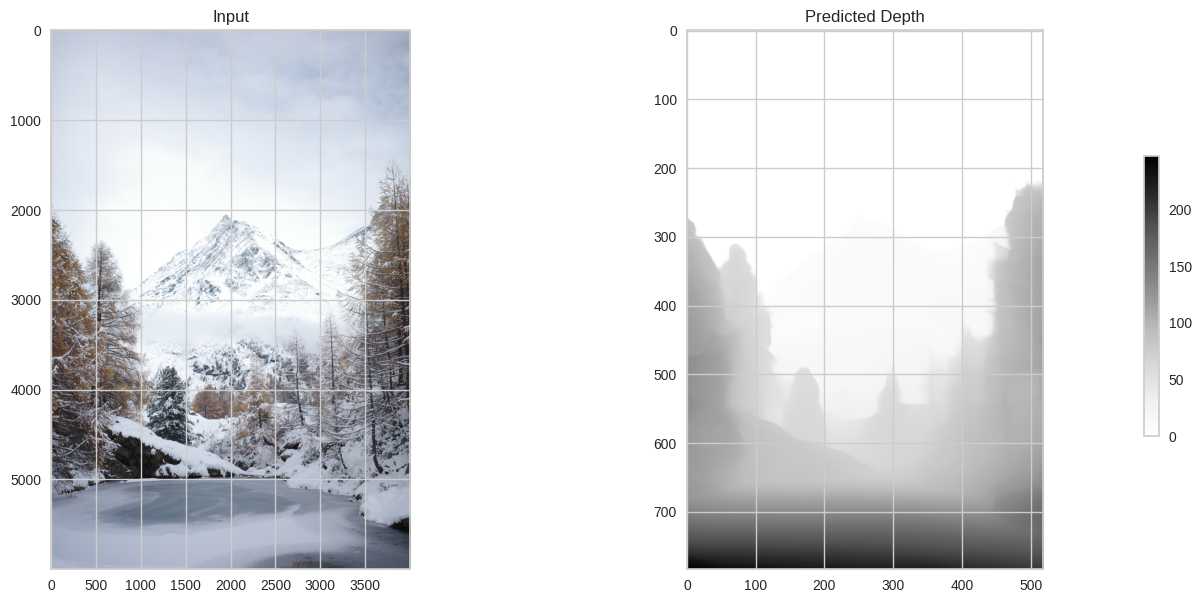

In [ ]:
plt.figure(figsize=(15,7))

plt.subplot(121)
plt.title('Input')
plt.imshow(raw_image)

plt.subplot(122)
plt.title('Predicted Depth')
plt.imshow(depth)

plt.colorbar(cax = plt.axes([0.91, 0.3, 0.01, 0.4]))

# Automatic segmentation of all objects

In [ ]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

## Functions

In [ ]:
def show_anns(anns):
    if len(anns) == 0:
      return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
      m = ann['segmentation']
      color_mask = np.concatenate([np.random.random(3), [0.35]])
      img[m] = color_mask
    ax.imshow(img)

In [ ]:
def show_all_segmts_ind(masks):
  for i, m in enumerate(masks):
      plt.figure(figsize=(15,7))
      mask = m['segmentation']
      mask = np.repeat(mask[:, :, np.newaxis], 3, axis=2)
      res = np.ones_like(img_lr)
      res[mask] = img_lr[mask]
      plt.imshow(res)
      plt.show()

In [ ]:
def downsample_image_opencv(img, output_size):
    height, width = img.shape[:2]
    new_height, new_width = output_size

    resized_img = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_AREA)

    return resized_img

def downsample_image_opencv2(img, output_size=(518, 518)):
    # the output size is same as the depth mapping

    height, width = img.shape[:2]

    ratio = min(output_size[0] / width, output_size[1] / height)
    new_width = int(width * ratio)
    new_height = int(height * ratio)

    resized_img = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_AREA)
    for n in range(resized_img.shape[0]):
      for m in range(resized_img.shape[1]):
        for k in range(resized_img.shape[2]):
          if resized_img[n,m,k] > 1:
            resized_img[n,m,k] = 1.0

    return resized_img

In [ ]:
def remove_small_masks(masks, thrd = 500):
  large_masks =[]
  for i, m in enumerate(masks):
    mask = m['segmentation']
    if np.sum(mask) > thrd:
      large_masks.append(m)

  return large_masks

In [ ]:
def remove_overlapping(masks, ovlp_r_thrd=0.05):
  embedded_objects = []

  for i in range(len(masks)):
    for j in range(i + 1, len(masks)):
      overlap_area = np.logical_and(masks[i]['segmentation'], masks[j]['segmentation'])

      overlap_size = np.sum(overlap_area)

      mask_i_size = np.sum(masks[i]['segmentation'])
      mask_j_size = np.sum(masks[j]['segmentation'])

      # Calculate the percentage of overlap, relative to smaller masks
      if overlap_size > 0:  # Ensure overlap
        overlap_ratio = round(overlap_size / min(mask_i_size, mask_j_size),4)
        if overlap_ratio > ovlp_r_thrd:
          if mask_i_size > mask_j_size:
            embedded_objects.append(j)
          else:
            embedded_objects.append(i)
        # else:
        #     print(f"There is no overlap between Mask {i} and Mask {j}.")
  non_ovlp_object_masks = np.delete(masks, embedded_objects).tolist()

  return embedded_objects, non_ovlp_object_masks

In [ ]:
def obtain_rest_of_img(object_masks, orignial_img):
  combined_mask = np.sum([m['segmentation'] for m in object_masks], axis=0)
  unsegmented_part = np.where(combined_mask > 0, 0, 1)
  res_img = np.ones_like(orignial_img)
  for i in range(3):
    res_img[:, :, i][unsegmented_part == 1] = orignial_img[:, :, i][unsegmented_part == 1]

  return res_img

In [ ]:
def img_white_p_ratio(img):
  return np.sum(img == 1.0)/(img.shape[0]*img.shape[1]*img.shape[2])

In [ ]:
def remove_white_canva(res_img, res_masks):
  white_canva_masks = []
  for i, m in enumerate(res_masks):
    mask = m["segmentation"]
    mask = np.repeat(mask[:, :, np.newaxis], 3, axis=2)
    masked_img = res_img * mask

    total_pixels = np.sum(mask)
    if total_pixels > 0:
        ones_ratio = img_white_p_ratio(masked_img)
        # print(f"Proportion of pixels in Mask {i} with value equal to 1: {ones_ratio:.4f}")
        if ones_ratio > 0.5:
          white_canva_masks.append(i)
    # else:
        # print(f"Mask {i} does not cover any area")

  res_masks_no_white_bg = np.delete(res_masks, white_canva_masks).tolist()

  return res_masks_no_white_bg

In [ ]:
def obtain_all_objects(img_to_procd, img_w_r_thrd=0.90, diff_thrd=0.01, n_thrd=3):

  n = 0
  diff = 1
  object_masks = []
  rows = img_to_procd.shape[0]
  cols = img_to_procd.shape[1]
  img_w_r = img_white_p_ratio(img_to_procd)

  orignial_img = img_to_procd

  while img_w_r < img_w_r_thrd and diff > diff_thrd and n <= n_thrd:

    masks = mask_generator.generate(img_to_procd)
    if n > 0:
      masks = remove_white_canva(img_to_procd, masks)

    large_masks = remove_small_masks(masks)
    object_masks.extend(large_masks)
    embedded_objects, object_masks = remove_overlapping(object_masks)

    # check_overlapping(object_masks)

    res_img = obtain_rest_of_img(object_masks, orignial_img)

    img_w_r = img_white_p_ratio(res_img)
    diff = np.sum(np.abs(res_img - img_to_procd))/(rows*cols)
    n += 1
    print(f"Iteration n={n}: white pixel raito after segmentation = {img_w_r}, difference ={diff}")

    img_to_procd = res_img

  return object_masks

In [ ]:
def check_overlapping(masks):
  n = 0
  for i in range(len(masks)):
    for j in range(i + 1, len(masks)):
      overlap_area = np.logical_and(masks[i]['segmentation'], masks[j]['segmentation'])

      overlap_size = np.sum(overlap_area)

      mask_i_size = np.sum(masks[i]['segmentation'])
      mask_j_size = np.sum(masks[j]['segmentation'])

      # Calculate the percentage of overlap, relative to smaller masks
      if overlap_size > 0:  # Ensure overlap
        overlap_ratio = round(overlap_size / min(mask_i_size, mask_j_size),4)
        if overlap_ratio > 0.05:
          n += 1
          print(f"The overlap ratio between Mask {i} and Mask {j} is. {overlap_ratio}")
    # else:
    #     print(f"There is no overlap between Mask {i} and Mask {j}.")

  if n == 0:
    print("There is no overlap")

## Procedure

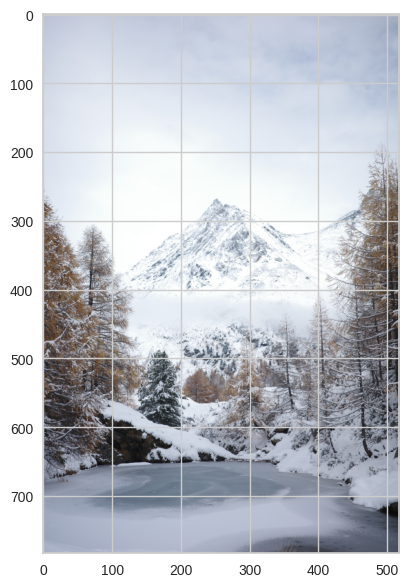

In [ ]:
# Dowsample the original image
img_lr = downsample_image_opencv(raw_image, depth.shape)
plt.figure(figsize=(15,7))
plt.imshow(img_lr)
plt.show()

In [ ]:
object_masks = obtain_all_objects(img_lr)

Iteration n=1: white pixel raito after segmentation = 0.8099809904656844, difference =0.5708927347868457
Iteration n=2: white pixel raito after segmentation = 0.9786487471436451, difference =0.22893807388617177


In [ ]:
check_overlapping(object_masks)

There is no overlap


There is 13 object masks


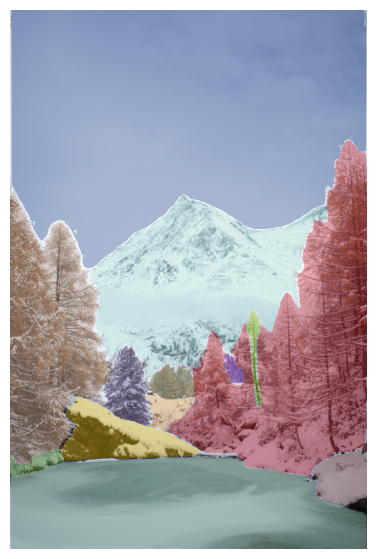

In [ ]:
print(f"There is {len(object_masks)} object masks")
plt.figure(figsize=(15,7))
plt.imshow(img_lr)
show_anns(object_masks)
plt.axis('off')
plt.show()

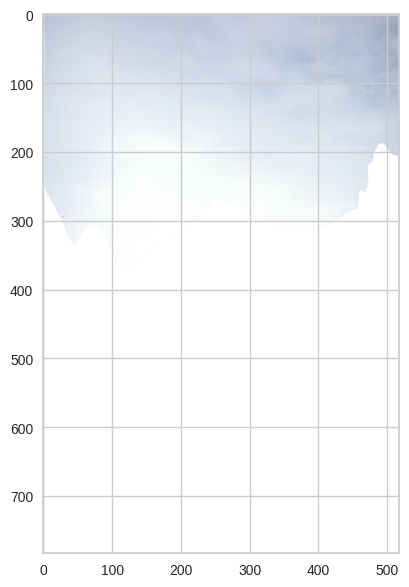

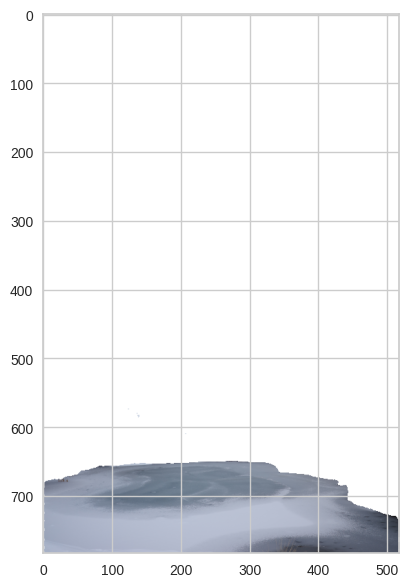

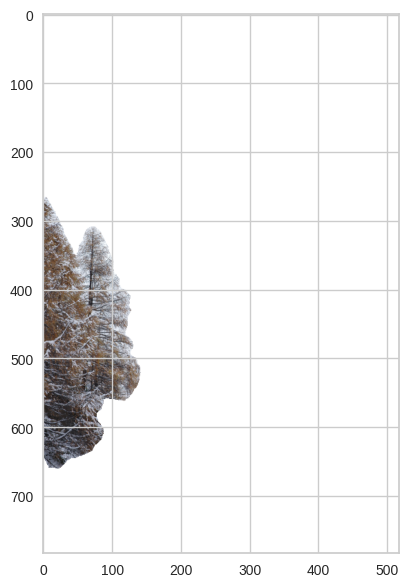

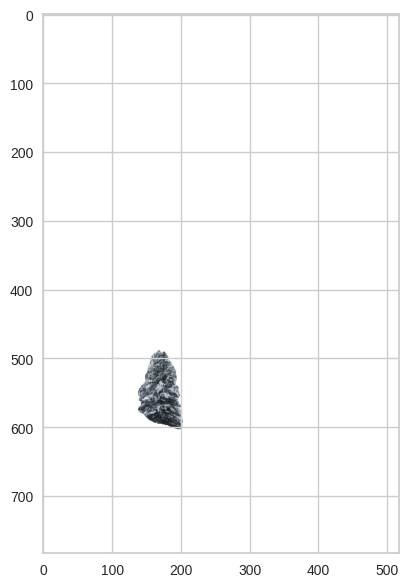

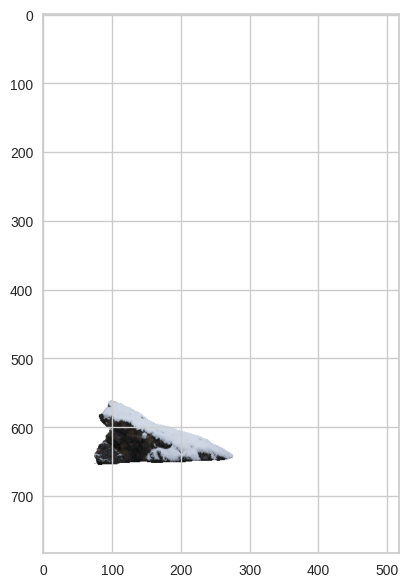

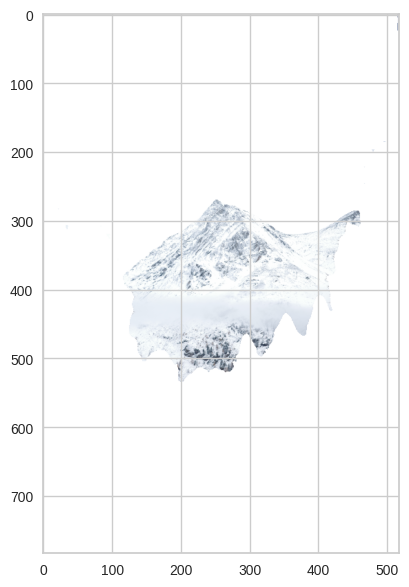

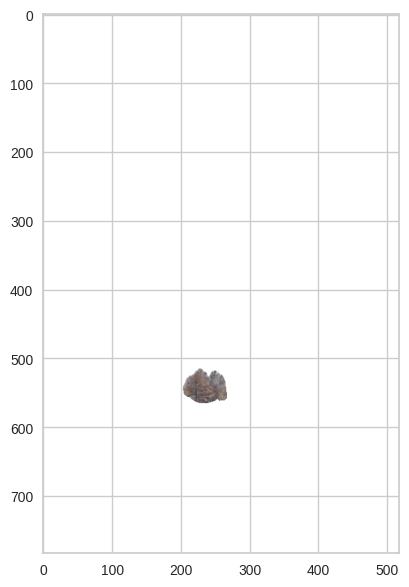

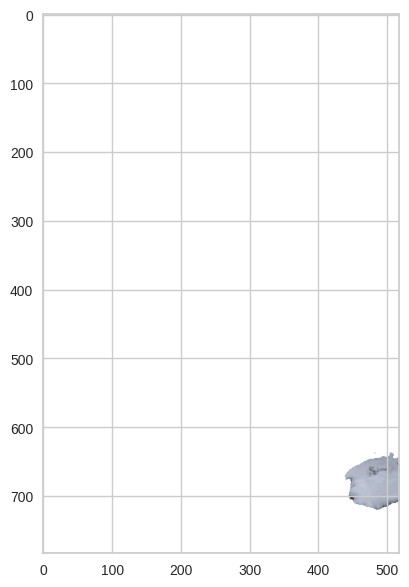

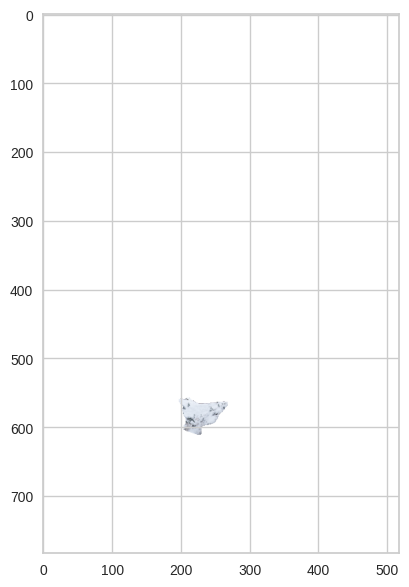

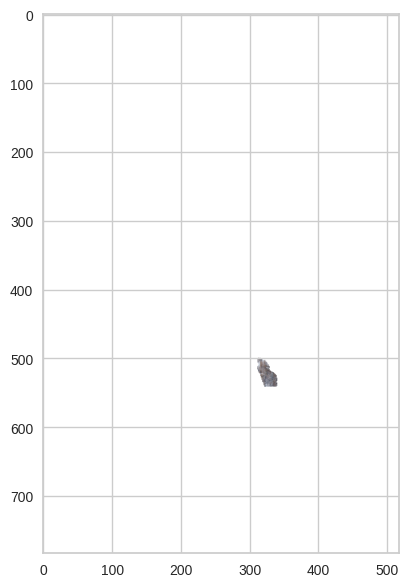

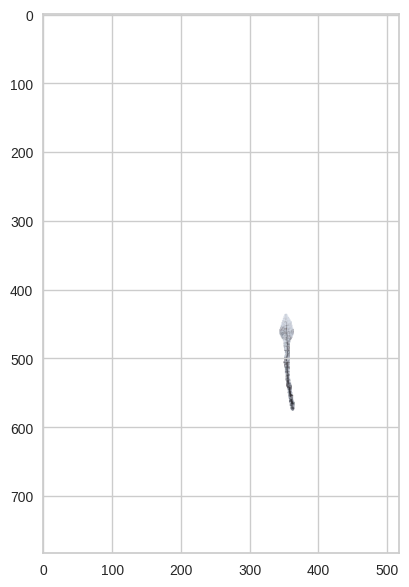

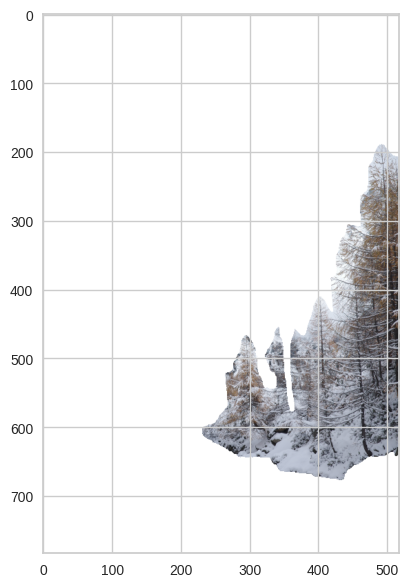

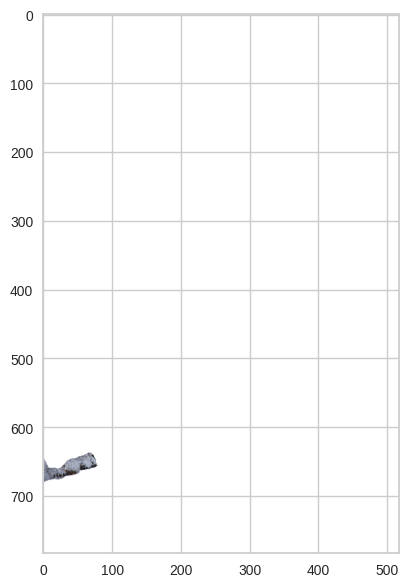

In [ ]:
show_all_segmts_ind(object_masks)

# Assign objects to layers based on depth

In [ ]:
def show_layers(img,object_masks,groups):
  plt.figure(figsize=(10, 8))

  for i, group in enumerate(groups):
    if len(group) == 0:
        continue

    ax = plt.subplot(2, 2, i + 1)

    res_img = np.zeros_like(img)
    for idx in group:
      mask = object_masks[idx]['segmentation']
      m = np.repeat(mask[:, :, np.newaxis], 3, axis=2)
      res_img += img*m
    ax.imshow(res_img)

    ax.axis('off')
    ax.set_title(f'Group {i+1}')

  plt.tight_layout()
  plt.show()

In [ ]:
def assign2layers_avg_obj(object_masks, depth, n_layers=4):
    # Step 1: Calculate the average depth of each mask
    average_depths = []
    for m in object_masks:
        mask = m["segmentation"]
        # Calculate the average depth of the depth map region corresponding to mask
        average_depth = np.mean(depth[mask])
        average_depths.append(average_depth)

    # Step 2: Sort objects by average depth
    sorted_indices = np.argsort(average_depths)

    # Step 3: Assign objects to layers
    # Calculate the minimum number of objects per layer
    objects_per_layer = len(object_masks) // n_layers
    # Calculate the number of objects to be distributed in the first few layers
    extra_objects = len(object_masks) % n_layers

    layers = []
    layers_inx = []
    start_idx = 0
    for i in range(n_layers):
        if i < extra_objects:
            # Assign one extra object to this layer
            end_idx = start_idx + objects_per_layer + 1
        else:
            end_idx = start_idx + objects_per_layer

        # Selected sorted objects for each layer
        layer_indices = sorted_indices[start_idx:end_idx]
        layer = [object_masks[index] for index in layer_indices]
        layers.append(layer)
        layers_inx.append(layer_indices)
        start_idx = end_idx

    return layers_inx, layers

In [ ]:
def assign2layers_kmeans(object_masks, depth, n_layers=4):
  # Step 1: Calculate the average depth of each mask
  average_depths = []
  for m in object_masks:
    mask = m["segmentation"]
    average_depth = np.mean(depth[mask])
    average_depths.append(average_depth)

  # Convert average_depths to shapes suitable for KMeans inputs
  average_depths_np = np.array(average_depths).reshape(-1, 1)

  # Step 2: Use K-means to cluster objects
  kmeans = KMeans(n_clusters=n_layers, random_state=0).fit(average_depths_np)
  labels = kmeans.labels_

  # Get the centers of clustering and sort these centers by depth
  centers = kmeans.cluster_centers_.flatten()
  sorted_centers_indices = np.argsort(centers)

  # Reassign labels based on sorted centers
  sorted_labels = np.zeros_like(labels)
  for old_label, new_label in enumerate(sorted_centers_indices):
    sorted_labels[labels == old_label] = new_label

  # Step 3: Assign objects to layers based on K-means clusters
  layers = [[] for _ in range(n_layers)]
  layers_inx = [[] for _ in range(n_layers)]
  for i, label in enumerate(sorted_labels):
    layers[label].append(object_masks[i])
    layers_inx[label].append(i)

  return layers_inx, layers

In [80]:
layers_idx, layers = assign2layers_avg_obj(object_masks, depth.numpy(), 3)

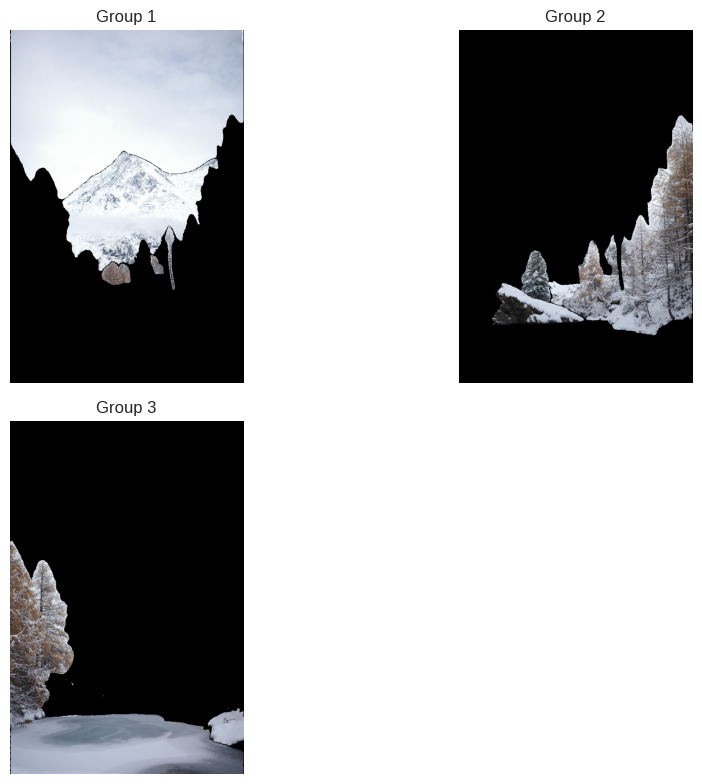

In [81]:
show_layers(img_lr, object_masks, layers_idx)

In [ ]:
layers_idx, layers = assign2layers_kmeans(object_masks, depth.numpy(), 4)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


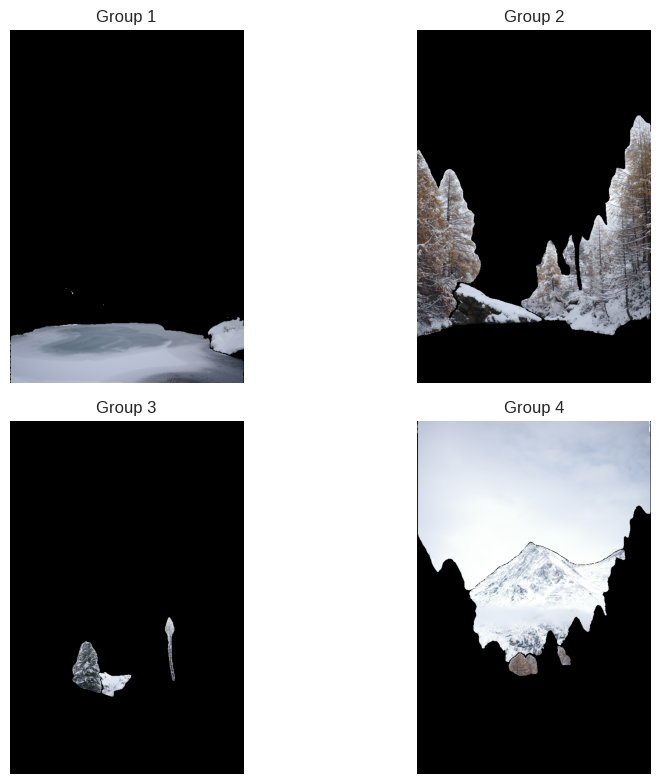

In [ ]:
show_layers(img_lr, object_masks, layers_idx)


---





---



# Test: Manually segment all objects

## Segment Images

In [ ]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

### Automatic mask generation

In [ ]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

In [ ]:
mask_generator_2 = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.90,
    stability_score_thresh=0.95,
    crop_n_layers=1,
    # crop_overlap_ratio=0.1,
    crop_n_points_downscale_factor=1,
    min_mask_region_area=9000  # Requires open-cv to run post-processing
)

In [ ]:
def downsample_image_opencv(img, output_size=(518, 518)):
    height, width = img.shape[:2]

    ratio = min(output_size[0] / width, output_size[1] / height)
    new_width = int(width * ratio)
    new_height = int(height * ratio)

    resized_img = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_AREA)
    for n in range(resized_img.shape[0]):
      for m in range(resized_img.shape[1]):
        for k in range(resized_img.shape[2]):
          if resized_img[n,m,k] > 1:
            resized_img[n,m,k] = 1.0

    return resized_img

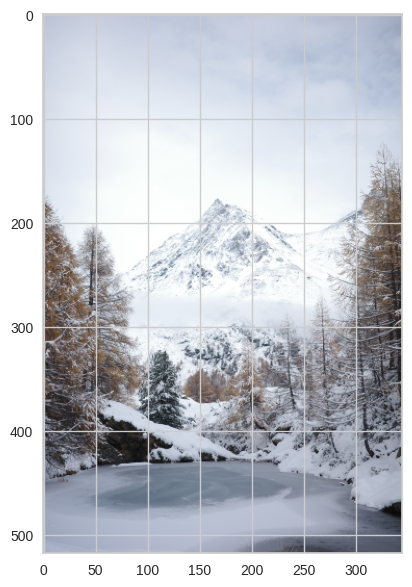

In [ ]:
img_lr = downsample_image_opencv(raw_image)
plt.figure(figsize=(15,7))
plt.imshow(img_lr)
plt.show()

In [ ]:
masks = mask_generator.generate(img_lr)
print(len(masks))
print(masks[0].keys())

44
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


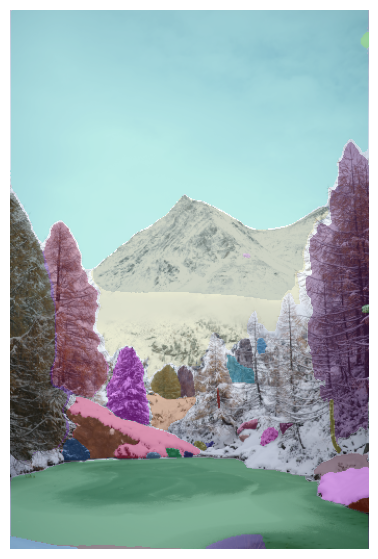

In [ ]:
plt.figure(figsize=(15,7))
plt.imshow(img_lr)
show_anns(masks)
plt.axis('off')
plt.show()

In [ ]:
def show_segmts(masks):
  for i, m in enumerate(masks):
      mask = m['segmentation']
      mask = np.repeat(mask[:, :, np.newaxis], 3, axis=2)
      res = np.ones_like(img_lr)
      res[mask] = img_lr[mask]
      plt.imshow(res)
      plt.show()

### Obtain all objects by segmenting

In [ ]:
# Ignore small chunks
object_masks =[]
thrd = 500
for i, m in enumerate(masks):
    mask = m['segmentation']
    if np.sum(mask) > thrd:
      object_masks.append(m)

In [ ]:
len(object_masks)

22

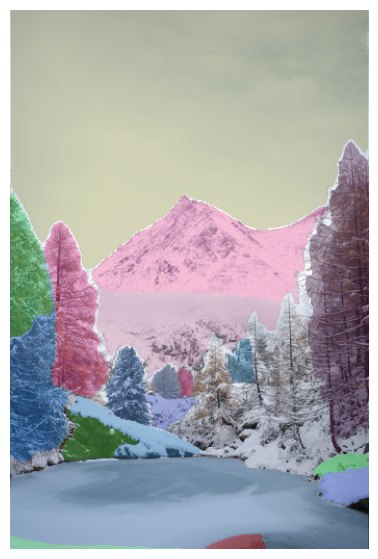

In [ ]:
plt.figure(figsize=(15,7))
plt.imshow(img_lr)
show_anns(object_masks)
plt.axis('off')
plt.show()

In [ ]:
# Check overlapping
masks = [m['segmentation'] for m in object_masks]
summed_masks = np.sum(masks, axis=0)
overlap = np.any(summed_masks > 1)
overlap

True

In [ ]:
embedded_objects = []

In [ ]:
for i in range(len(masks)):
    for j in range(i + 1, len(masks)):
        overlap_area = np.logical_and(masks[i], masks[j])

        overlap_size = np.sum(overlap_area)

        mask_i_size = np.sum(masks[i])
        mask_j_size = np.sum(masks[j])

        # Calculate the percentage of overlap, relative to smaller masks
        if overlap_size > 0:  # Ensure overlap
            overlap_ratio = round(overlap_size / min(mask_i_size, mask_j_size),4)
            if overlap_ratio > 0.05:
              print(f"The overlap ratio between Mask {i} and Mask {j} is. {overlap_ratio}")
            if overlap_ratio > 0.95:
              if mask_i_size > mask_j_size:
                print(f"Mask {j} is embedded in Mask {i}")
                embedded_objects.append(j)
              else:
                print(f"Mask {i} is embedded in Mask {j}")
                embedded_objects.append(i)
        # else:
        #     print(f"There is no overlap between Mask {i} and Mask {j}.")

The overlap ratio between Mask 2 and Mask 4 is. 0.9992
Mask 2 is embedded in Mask 4
The overlap ratio between Mask 2 and Mask 17 is. 0.9829
Mask 17 is embedded in Mask 2
The overlap ratio between Mask 2 and Mask 21 is. 1.0
Mask 21 is embedded in Mask 2
The overlap ratio between Mask 3 and Mask 5 is. 0.9852
Mask 5 is embedded in Mask 3
The overlap ratio between Mask 3 and Mask 7 is. 0.9989
Mask 7 is embedded in Mask 3
The overlap ratio between Mask 3 and Mask 8 is. 0.9769
Mask 8 is embedded in Mask 3
The overlap ratio between Mask 3 and Mask 19 is. 0.9962
Mask 19 is embedded in Mask 3
The overlap ratio between Mask 4 and Mask 17 is. 0.9829
Mask 17 is embedded in Mask 4
The overlap ratio between Mask 4 and Mask 21 is. 1.0
Mask 21 is embedded in Mask 4
The overlap ratio between Mask 5 and Mask 8 is. 0.9954
Mask 5 is embedded in Mask 8
The overlap ratio between Mask 6 and Mask 15 is. 0.9885
Mask 15 is embedded in Mask 6
The overlap ratio between Mask 7 and Mask 19 is. 0.9932
Mask 19 is emb

In [ ]:
non_ovlp_object_masks = np.delete(object_masks, embedded_objects).tolist()

The number of obejcts: 22


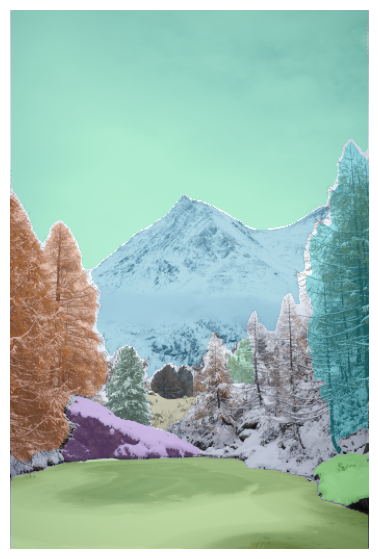

In [ ]:
print(f"The number of obejcts: {len(object_masks)}")
plt.figure(figsize=(15,7))
plt.imshow(img_lr)
show_anns(non_ovlp_object_masks)
plt.axis('off')
plt.show()

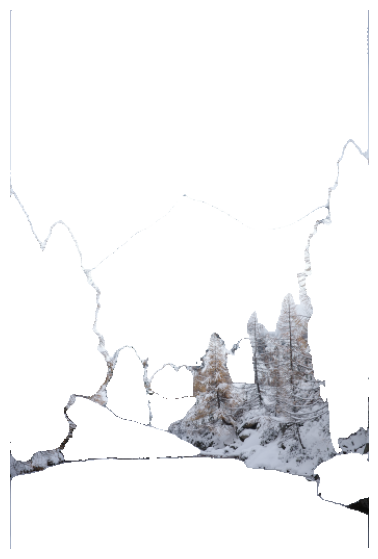

In [ ]:
combined_mask = np.sum([m['segmentation'] for m in non_ovlp_object_masks], axis=0)
unsegmented_part = np.where(combined_mask > 0, 0, 1)
# m = np.repeat(unsegmented_part[:, :, np.newaxis], 3, axis=2)
res_img = np.ones_like(img_lr)
# res[m] = img_lr[m]
for i in range(3):
    res_img[:, :, i][unsegmented_part == 1] = img_lr[:, :, i][unsegmented_part == 1]

plt.figure(figsize=(15,7))
plt.imshow(res_img)
plt.axis('off')
plt.show()

In [ ]:
# Segment the rest of the image
res_masks = mask_generator.generate(res_img)
print(len(res_masks))
print(res_masks[0].keys())

21
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


In [ ]:
# remove white canva masks
white_canva_masks = []
for i, m in enumerate(res_masks):
    mask = m["segmentation"]
    mask = np.repeat(mask[:, :, np.newaxis], 3, axis=2)
    masked_img = res_img * mask

    total_pixels = np.sum(mask)
    if total_pixels > 0:
        # ones_ratio = np.sum(masked_img) / total_pixels
        ones_ratio = img_white_p_ratio(masked_img)
        print(f"Proportion of pixels in Mask {i} with value equal to 1: {ones_ratio:.4f}")
        if ones_ratio > 0.1:
          white_canva_masks.append(i)
    else:
        print(f"Mask {i} does not cover any area")

Proportion of pixels in Mask 0 with value equal to 1: 0.8580
Proportion of pixels in Mask 1 with value equal to 1: 0.1421
Proportion of pixels in Mask 2 with value equal to 1: 0.0001
Proportion of pixels in Mask 3 with value equal to 1: 0.0113
Proportion of pixels in Mask 4 with value equal to 1: 0.0113
Proportion of pixels in Mask 5 with value equal to 1: 0.1417
Proportion of pixels in Mask 6 with value equal to 1: 0.0000
Proportion of pixels in Mask 7 with value equal to 1: 0.0236
Proportion of pixels in Mask 8 with value equal to 1: 0.0000
Proportion of pixels in Mask 9 with value equal to 1: 0.0000
Proportion of pixels in Mask 10 with value equal to 1: 0.0002
Proportion of pixels in Mask 11 with value equal to 1: 0.3746
Proportion of pixels in Mask 12 with value equal to 1: 0.0001
Proportion of pixels in Mask 13 with value equal to 1: 0.0000
Proportion of pixels in Mask 14 with value equal to 1: 0.0001
Proportion of pixels in Mask 15 with value equal to 1: 0.0001
Proportion of pixe

In [ ]:
res_masks_no_white_bg = np.delete(res_masks, white_canva_masks).tolist()

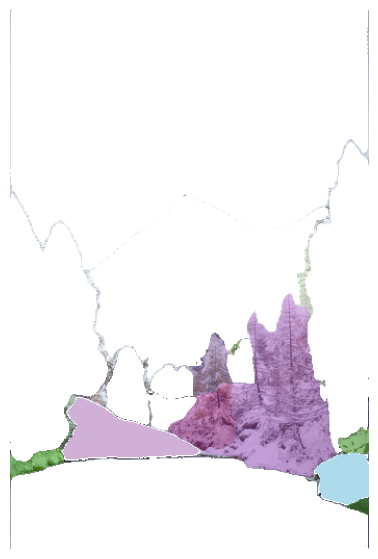

In [ ]:
plt.figure(figsize=(15,7))
plt.imshow(res_img)
show_anns(res_masks_no_white_bg)
plt.axis('off')
plt.show()

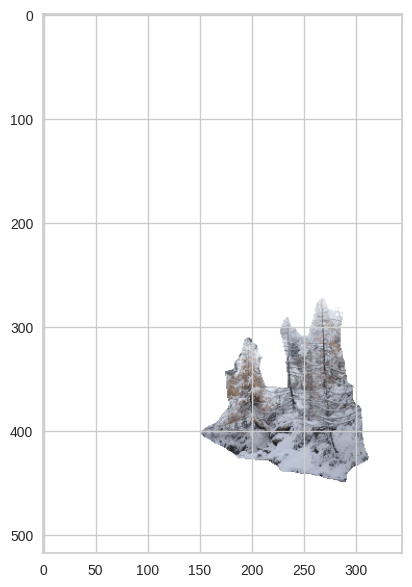

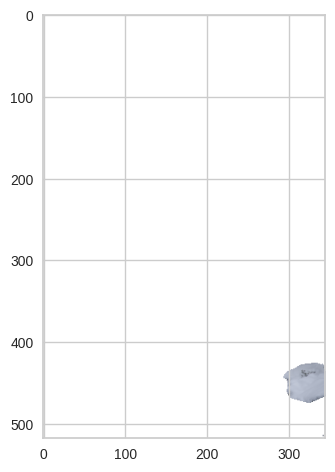

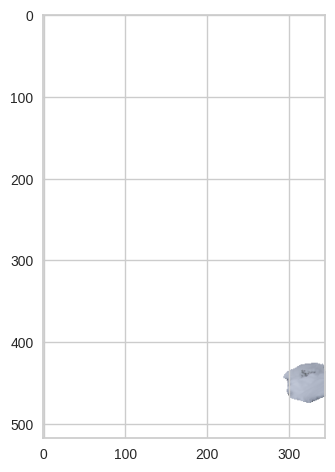

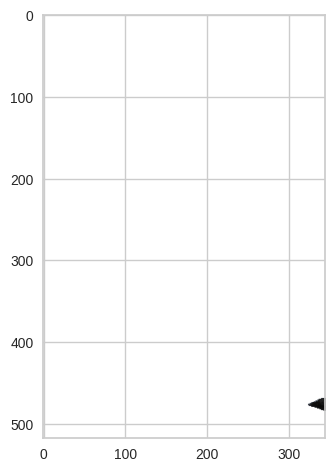

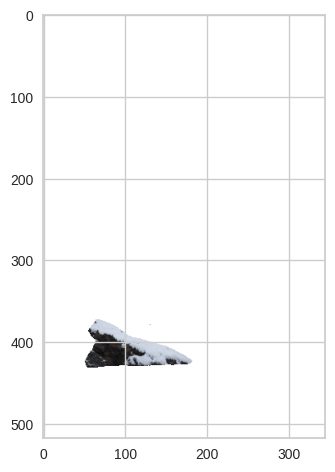

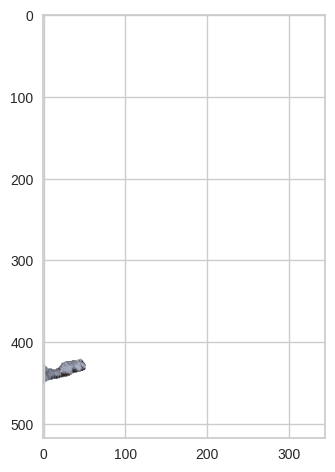

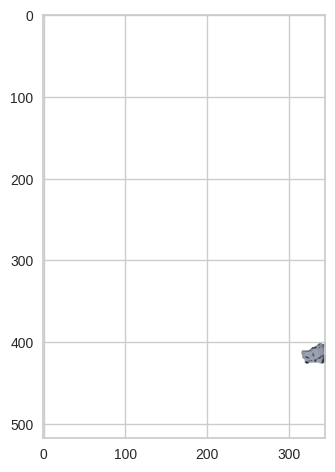

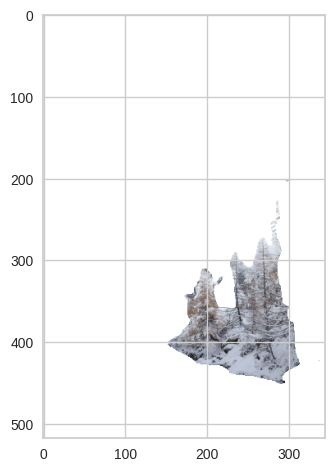

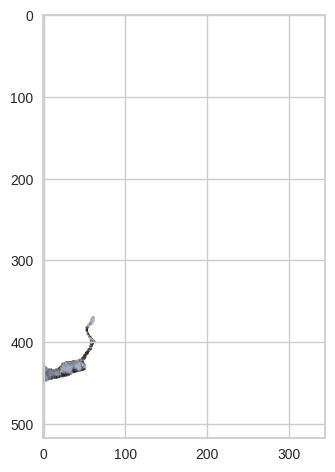

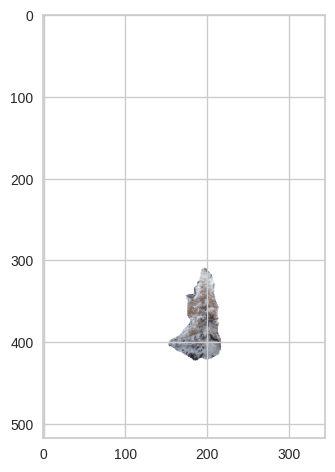

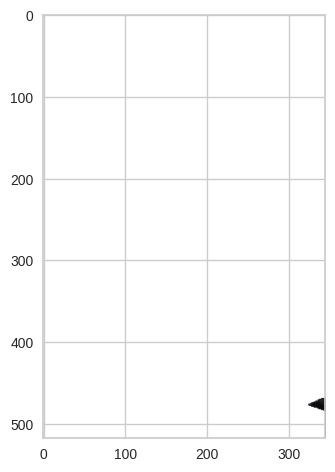

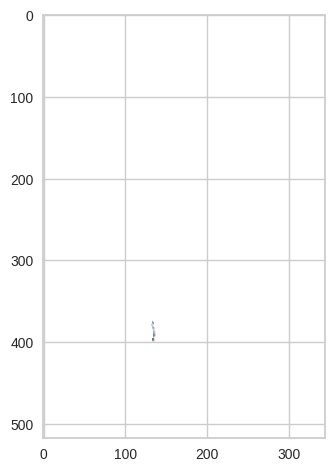

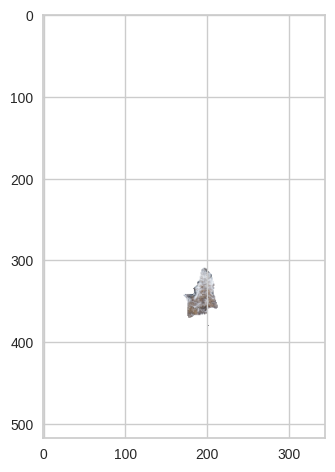

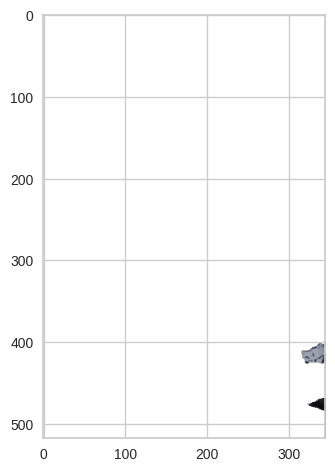

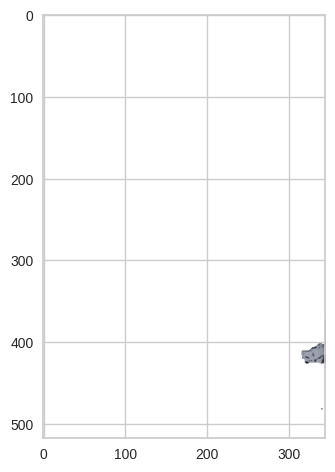

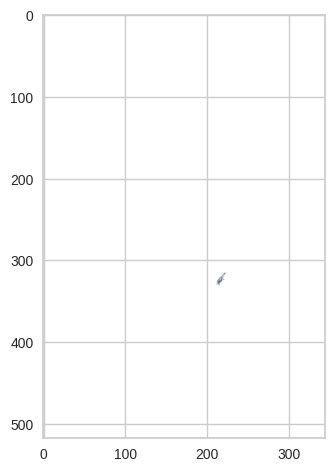

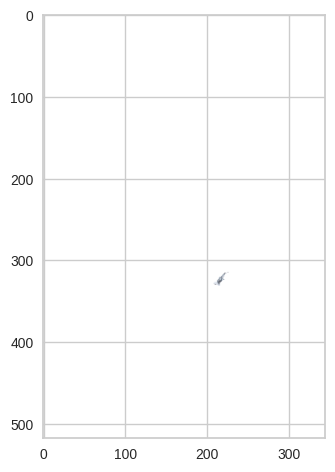

In [ ]:
plt.figure(figsize=(15,7))
show_segmts(res_masks_no_white_bg)